# Destilación de conocimientos para la detección no supervisada de anomalías


Este cuaderno implementa la destilación de conocimientos para la detección no supervisada de anomalías.

Nos basamos en el artículo [*Student-Teacher Feature Pyramid Matching for Anomaly Detection*](https://arxiv.org/pdf/2103.04257) y su [código asociado](https://github.com/xiahaifeng1995/STPM-Anomaly-Detection-Localization-master). La siguiente figura, extraída del artículo, muestra el funcionamiento del método:

![stpm](./images/stpm.png)


## Selección del *backbone* y del conjunto de datos


### *Backbone* y función de pérdida


El artículo utiliza [ResNet18](https://arxiv.org/pdf/1512.03385) como arquitectura de red, con el modelo *teacher* preentrenado en [ImageNet](https://www.image-net.org/). El modelo *student* usa la misma arquitectura, pero su red se inicializa aleatoriamente.

Como se muestra en la figura anterior, la función de pérdida se calcula sobre las salidas de los 3 primeros bloques de capas de ResNet18. Un bloque de capas corresponde al conjunto de capas que operan a la misma resolución de imagen. Así, el modelo *student* se entrena para replicar los *feature maps* del modelo *teacher* solo en estas 3 salidas. El puntaje de anomalía también se calcula sobre estas salidas.

La función de pérdida utilizada es simplemente la pérdida MSE (error cuadrático medio), que ya hemos visto. Esta pérdida se calcula para cada *feature map* y luego se suman para obtener la pérdida total.


### Conjunto de datos


El conjunto de datos utilizado en el artículo es [MVTEC AD](https://www.mvtec.com/company/research/datasets/mvtec-ad). Contiene 15 categorías, de las cuales 10 son objetos y 5 son texturas. Cada categoría incluye aproximadamente 350 imágenes sin defectos para el entrenamiento y alrededor de 100 imágenes defectuosas para las pruebas.

A continuación, se muestra una vista previa de las imágenes del conjunto de datos:

![mvtec](./images/mvtec.png)

Puedes descargar el conjunto de datos [aquí](https://www.mvtec.com/company/research/datasets/mvtec-ad). Para nuestra implementación, utilizaremos la categoría *hazelnut* (avellana).


## Implementación con PyTorch y *timm*


Algunas funciones son un poco complejas y no son esenciales para entender el concepto (como la carga del conjunto de datos, etc.). Para mayor claridad, estas funciones y clases se han movido al archivo `utils.py`, que puedes consultar si lo necesitas.


In [1]:
import matplotlib.pyplot as plt
from utils import MVTecDataset,cal_anomaly_maps
import torch
import torch.nn as nn
import timm
import torch.nn.functional as F
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/aquilae/anaconda3/envs/dev/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Conjunto de datos


Comencemos cargando el conjunto de datos y echemos un vistazo a su contenido.
Esta vez, dividiremos el entrenamiento en dos partes: entrenamiento y validación, para poder evaluar el modelo durante el proceso.


In [2]:
train_dataset = MVTecDataset(root_dir="../data/mvtec/hazelnut/train/good",resize_shape=[256,256],phase='train')
test_dataset = MVTecDataset(root_dir="../data/mvtec/hazelnut/test/",resize_shape=[256,256],phase='test')
print("taille du dataset d'entrainement : ",len(train_dataset))
print("taille du dataset de test : ",len(test_dataset))
print("taille d'une image : ",train_dataset[0]['imageBase'].shape)

# Séparation du dataset d'entrainement en train et validation
img_nums = len(train_dataset)
valid_num = int(img_nums * 0.2)
train_num = img_nums - valid_num
train_data, val_data = torch.utils.data.random_split(train_dataset, [train_num, valid_num])

# Création des dataloaders
train_loader=torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True)
val_loader=torch.utils.data.DataLoader(val_data, batch_size=4, shuffle=True)
test_loader=torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)


taille du dataset d'entrainement :  391
taille du dataset de test :  110
taille d'une image :  (3, 256, 256)


Podemos visualizar algunos defectos:


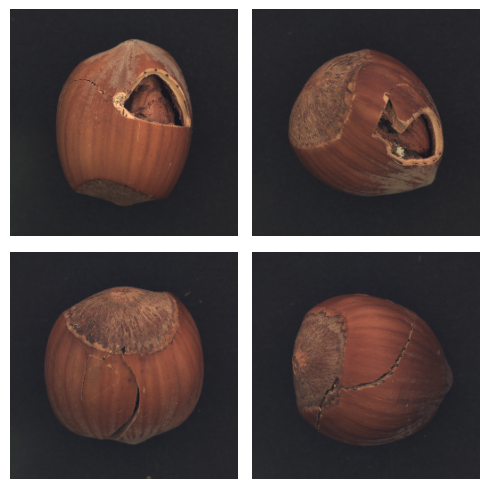

In [3]:
num_defects_displayed = 0
fig, axes = plt.subplots(2, 2, figsize=(5, 5))

for sample in test_loader:
  image = sample['imageBase']
  has_defect = sample['has_anomaly']
  if has_defect:
    row = num_defects_displayed // 2
    col = num_defects_displayed % 2
    
    axes[row, col].imshow(image.squeeze().permute(1, 2, 0).numpy())
    axes[row, col].axis('off')  
    
    num_defects_displayed += 1
    
    if num_defects_displayed == 4:
      break
plt.tight_layout()
plt.show()

### Creación de los modelos *teacher* y *student*


Para nuestros modelos, usaremos la misma clase y especificaremos las particularidades de cada modelo mediante parámetros.
Para facilitar el uso de un *backbone* existente, utilizamos la biblioteca [*timm*](https://timm.fast.ai/) (*PyTorch Image Models*). Esta biblioteca es muy útil para acceder a *backbones* y modelos preentrenados, y también ofrece flexibilidad para manipular la red.


In [4]:
class resnet18timm(nn.Module):
    def __init__(self,backbone_name="resnet18",out_indices=[1,2,3],pretrained=True):
        super(resnet18timm, self).__init__()     
        # Features only permet permet de ne récupérer que les features et pas la sortie du réseau, out_indices permet de choisir les couches à récupérer
        self.feature_extractor = timm.create_model(backbone_name,pretrained=pretrained,features_only=True,out_indices=out_indices)
        if pretrained:
            # Si le modèle est pré-entrainé (donc c'est le teacher), on gèle les poids
            self.feature_extractor.eval() 
            for param in self.feature_extractor.parameters():
                param.requires_grad = False   
        
    def forward(self, x):
        features = self.feature_extractor(x)
        return features

Ahora podemos crear nuestro modelo *teacher* y *student*:


In [5]:
student=resnet18timm(backbone_name="resnet18",out_indices=[1,2,3],pretrained=False).to(device)
teacher=resnet18timm(backbone_name="resnet18",out_indices=[1,2,3],pretrained=True).to(device)

### Función de pérdida


La función de pérdida utiliza la distancia euclidiana (MSE), definida de la siguiente manera:
$D(I_1, I_2) = \sqrt{\sum_{i=1}^{m} \sum_{j=1}^{n} \left( I_1(i,j) - I_2(i,j) \right)^2}$, donde $I_1$ e $I_2$ son nuestras dos imágenes.

Nuestra implementación de la pérdida usa esta distancia para comparar los *feature maps* entre sí para las 3 parejas de *feature maps*:


In [6]:
class loss_kdad:
  def __init__(self):
    pass
  # fs_list : liste des features du student et ft_list : liste des features du teacher
  def __call__(self,fs_list, ft_list):
    t_loss = 0
    N = len(fs_list)
    for i in range(N):
      fs = fs_list[i]
      ft = ft_list[i]
      _, _, h, w = fs.shape
      # Normaliser les features améliore les résultats
      fs_norm = F.normalize(fs, p=2)
      ft_norm = F.normalize(ft, p=2)

      # Calcul de la distance euclidienne
      f_loss = 0.5 * (ft_norm - fs_norm) ** 2
      # On prend la moyenne de la loss sur tous les pixels
      f_loss = f_loss.sum() / (h * w)
      t_loss += f_loss

    return t_loss / N

### Entrenamiento del modelo


Definamos nuestros hiperparámetros:


In [7]:
epochs= 20
lr=0.0004
criterion = loss_kdad()
optimizer = torch.optim.Adam(student.parameters(), lr=lr)

¡Es hora de entrenar el modelo! El entrenamiento puede tomar algún tiempo.


In [8]:
for epoch in range(epochs):
    student.train()
    train_loss = 0.0
    for data in train_loader:
        image = data['imageBase'].to(device)
        optimizer.zero_grad()
        outputs_student = student(image)
        outputs_teacher = teacher(image)
        loss = criterion(outputs_student,outputs_teacher)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    student.eval()
    val_loss = 0.0
    for data in val_loader:
        image = data['imageBase'].to(device)
        outputs_student = student(image)
        outputs_teacher = teacher(image)
        loss = criterion(outputs_student,outputs_teacher)
        val_loss += loss.item()
    print("Epoch {} - train loss : {} - val loss : {}".format(epoch,train_loss/len(train_loader),val_loss/len(val_loader)))

Epoch 0 - train loss : 1.6731480107277255 - val loss : 1.3833315640687942
Epoch 1 - train loss : 0.8773692731238618 - val loss : 0.7371394574642182
Epoch 2 - train loss : 0.5567233881241158 - val loss : 0.5115290269255638
Epoch 3 - train loss : 0.4170471341172351 - val loss : 0.4163943402469158
Epoch 4 - train loss : 0.33714089627507365 - val loss : 0.3523293524980545
Epoch 5 - train loss : 0.29374887162371527 - val loss : 0.28786116763949393
Epoch 6 - train loss : 0.2577011583349373 - val loss : 0.2747397504746914
Epoch 7 - train loss : 0.2373752082827725 - val loss : 0.22077917009592057
Epoch 8 - train loss : 0.21801123603046696 - val loss : 0.2255100306123495
Epoch 9 - train loss : 0.2012799475577813 - val loss : 0.19499738812446593
Epoch 10 - train loss : 0.1874875887473927 - val loss : 0.20737174898386002
Epoch 11 - train loss : 0.17415884736029408 - val loss : 0.254209216684103
Epoch 12 - train loss : 0.16137944416532032 - val loss : 0.15532575249671937
Epoch 13 - train loss : 0.

Ahora podemos evaluar nuestro modelo. Para ello, utilizamos la métrica AUROC (consulta el [módulo 9](../09_EntrainementContrastif/01_FaceVerification.ipynb) para un repaso).


In [11]:
scores = []
test_imgs = []
gt_list = []
for sample in test_loader:
    label=sample['has_anomaly']
    image = sample['imageBase'].to(device)
    test_imgs.extend(image.cpu())
    gt_list.extend(label.cpu().numpy())
    with torch.set_grad_enabled(False):
        
        outputs_student = student(image)
        outputs_teacher = teacher(image) 

        # La fonction cal_anomaly_maps permet de calculer la carte d'anomalie (ça sera utile pour la visualisation après)
        score =cal_anomaly_maps(outputs_student,outputs_teacher,256) 
        
    scores.append(score)
scores = np.asarray(scores)
gt_list = np.asarray(gt_list)

from sklearn.metrics import roc_auc_score

map_scores = np.asarray(scores)

max_anomaly_score = map_scores.max()
min_anomaly_score = map_scores.min()
map_scores = (map_scores - min_anomaly_score) / (max_anomaly_score - min_anomaly_score)
img_scores = map_scores.reshape(map_scores.shape[0], -1).max(axis=1)
gt_list = np.asarray(gt_list)
img_roc_auc = roc_auc_score(gt_list, img_scores)
print(" image hazelnut ROCAUC : %.3f" % (img_roc_auc))


 image hazelnut ROCAUC : 0.990


Obtenemos un AUROC muy bueno, lo que indica que nuestro modelo es excelente para detectar defectos en las avellanas.


### Visualización del mapa de anomalías


Para calcular el puntaje, comparamos los *feature maps* del modelo *teacher* con los del *student* en las 3 salidas (de diferentes dimensiones). Usando la función `cal_anomaly_maps`, realizamos las comparaciones y reconstruimos un mapa de anomalías del tamaño de la imagen original. Podemos visualizar este mapa para obtener la localización del defecto.


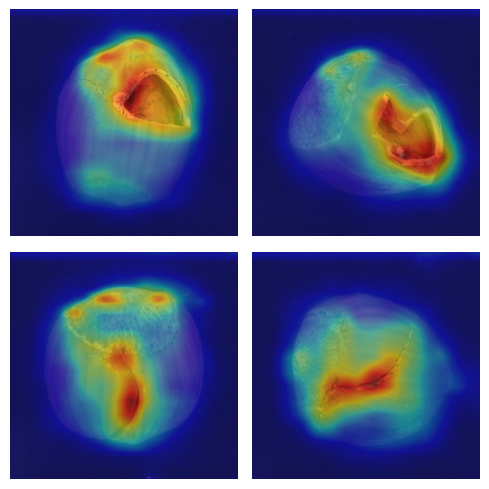

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(5, 5))

for i,(img,mask) in enumerate(zip(test_imgs,scores)):
    img_act=img.squeeze().permute(1, 2, 0).numpy()
    row = i // 2
    col = i % 2
    axs[row, col].imshow(img_act) 
    axs[row, col].imshow(mask, cmap='jet', alpha=0.5)
    axs[row, col].axis('off')
    if i==3:
        break
    
plt.tight_layout()
plt.show()


Observamos que la localización es bastante precisa, aunque no sea el objetivo principal de nuestro modelo.
